# Post Processing

**In this notebook:**

* Test DBSCAN for post processing

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/

# System libraries

In [22]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Environment

In [23]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder="/workspace/")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /workspace
 - Project folder: /workspace/our-git-project
 - Datasets folder: /workspace/our-git-project/datasets
 - Models folder: /workspace/our-git-project/models
 - Experiments folder: /workspace/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [24]:
dataset_params = {
    "prediction": "LabeledMask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": None
}

preprocessing_params = {
    'min_max_normalize': None,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
}


### Load Meta Data

In [25]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspace/our-git-project/datasets/A001_orig....,/workspace/our-git-project/datasets/A001_masks...,/workspace/our-git-project/datasets/A001_vesse...,/workspace/our-git-project/datasets/A001_label...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspace/our-git-project/datasets/A003_orig....,/workspace/our-git-project/datasets/A003_masks...,/workspace/our-git-project/datasets/A003_vesse...,/workspace/our-git-project/datasets/A003_label...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspace/our-git-project/datasets/A005_orig....,/workspace/our-git-project/datasets/A005_masks...,/workspace/our-git-project/datasets/A005_vesse...,/workspace/our-git-project/datasets/A005_label...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspace/our-git-project/datasets/A006_orig....,/workspace/our-git-project/datasets/A006_masks...,/workspace/our-git-project/datasets/A006_vesse...,/workspace/our-git-project/datasets/A006_label...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspace/our-git-project/datasets/A008_orig....,/workspace/our-git-project/datasets/A008_masks...,/workspace/our-git-project/datasets/A008_vesse...,/workspace/our-git-project/datasets/A008_label...


In [115]:
from aneurysm_utils import data_collection,postprocessing 
mir_images, vessel_labels, patients = data_collection.load_mri_images(env,df,prediction="vessel",case_list=case_list,resample_voxel_dim=None)

  0%|          | 0/13 [00:00<?, ?it/s]

In [116]:
case_list=["A001","A003","A005","A006","A008","A009","A010","A012","A014","A015","A016","A017_L_","A018","A019"]

mir_images, aneurysm_labels, patients = data_collection.load_mri_images(env,df,prediction="mask",case_list=case_list)
mir_images, invidiual_aneurysm_labels, patients = data_collection.load_mri_images(env,df,prediction="labeled",case_list=case_list)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [117]:

postprocess_dict={ 
    "dbscan":True,
    "remove_border_candidates":True,
    "resample":True,
    "evaluate_dbscan":True,
    "invidual_aneurysm_labels":invidiual_aneurysm_labels,
    "cases": patients
                      
}

In [118]:
for image in aneurysm_labels:
    print(np.unique(image))

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [119]:
np.array(np.where(aneurysm_labels[0]==1)).T
mri_imgs= postprocessing.postprocess(env,aneurysm_labels,postprocess_dict)

[INFO] Postprocessing: DBSCAN...
[INFO] Postprocessing: Evaluating DBSCAN
[INFO] {'A001': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A003': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A005': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A006': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A008': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A009': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A010': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A012': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A014': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A015': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A016': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A018': {'predicted_cluster_1': {'true_cluster_1': 1.0}}, 'A019': {'predicted_cluster_1': {'true_cluster_1': 1.0}}}
[INFO] Postprocessing: Removing border candidates...
[INFO] Postprocessing: Resample to Size(256, 256, 220)


In [120]:
bounding_boxes =postprocessing.bounding_boxes(mri_imgs,patients)

[0. 1.]
[-0.  1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[-0.  1.]
[0. 1.]
[0. 1.]
[-0.  1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [124]:
print(vessel_labels[9].shape)
mri_imgs[9].shape

(256, 256, 220)


(256, 256, 220)

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


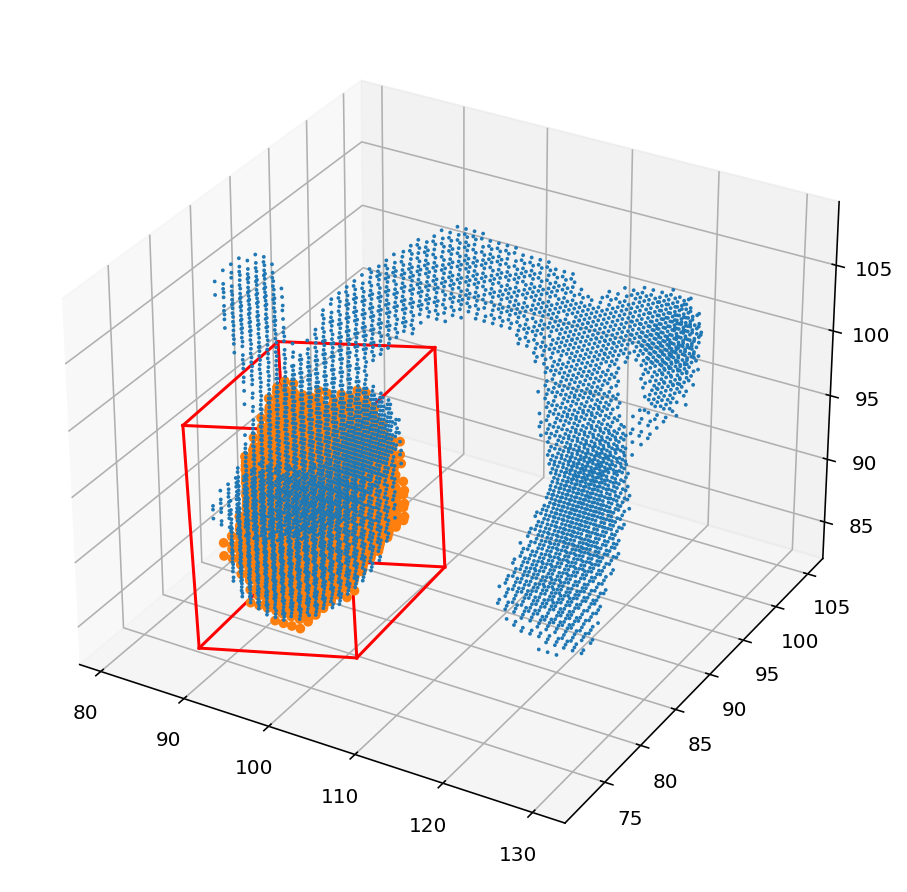

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [139]:
evaluation.draw_bounding_box(bounding_boxes[9]["candidates"],aneurysm_array=mri_imgs[9],vessel_array=vessel_labels[9])

In [133]:
print(mri_imgs[9].shape)

(256, 256, 220)
